In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Số lượng vùng trắng được tìm thấy: 169
Các cặp mắt: [(2, 3), (4, 5), (6, 7), (9, 12), (11, 13), (14, 15), (16, 17), (18, 19), (21, 22), (23, 24), (25, 29), (26, 27), (28, 30), (31, 32), (33, 34), (35, 36), (37, 38), (40, 41), (43, 45), (44, 46), (47, 48), (49, 50), (51, 52), (54, 55), (56, 58), (57, 59), (60, 61), (62, 63), (64, 66), (65, 67), (68, 69), (71, 74), (72, 77), (75, 76), (78, 79), (80, 81), (82, 83), (84, 86), (87, 88), (90, 89), (91, 93), (92, 94), (95, 98), (96, 99), (97, 100), (101, 102), (105, 108), (106, 114), (107, 110), (109, 111), (112, 113), (116, 117), (118, 119), (120, 122), (121, 128), (123, 125), (124, 127), (126, 129), (130, 131), (132, 134), (133, 135), (136, 137), (138, 141), (139, 140), (142, 146), (143, 144), (147, 151), (149, 150), (152, 154), (153, 156), (155, 160), (157, 161), (158, 162), (159, 163), (164, 166), (165, 167)]
Mắt đơn lẻ: [0, 1, 70, 39, 8, 73, 10, 42, 103, 104, 168, 145, 115, 20, 53, 85, 148, 89]
Số lượng bounding box màu xanh biển (cặp mắ

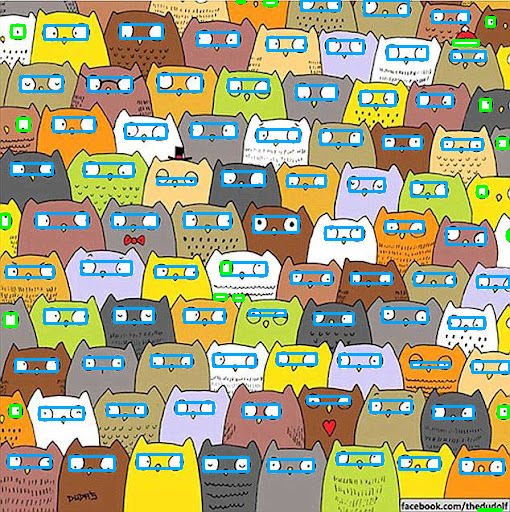

In [2]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import math

# Hàm flood-fill để tìm diện tích của vùng trắng và đánh dấu vùng đó
def flood_fill(image, x, y, fill_color):
    stack = [(x, y)]
    area = 0
    original_color = image[y, x]

    # Biến để lưu lại tọa độ tối thiểu và tối đa của các pixel trong vùng
    min_x, max_x = x, x
    min_y, max_y = y, y

    while stack:
        x, y = stack.pop()

        if image[y, x] == original_color:
            image[y, x] = fill_color
            area += 1

            # Cập nhật tọa độ tối thiểu và tối đa
            min_x = min(min_x, x)
            max_x = max(max_x, x)
            min_y = min(min_y, y)
            max_y = max(max_y, y)

            # Thêm các pixel lân cận vào stack để kiểm tra
            if x > 0:
                stack.append((x - 1, y))
            if x < image.shape[1] - 1:
                stack.append((x + 1, y))
            if y > 0:
                stack.append((x, y - 1))
            if y < image.shape[0] - 1:
                stack.append((x, y + 1))

    # Trả về diện tích và bounding box của vùng
    return area, (min_x, min_y, max_x, max_y)

# Hàm kiểm tra xem một pixel có phải là biên không (màu trắng có màu đen kề bên)
def is_border(image, x, y):
    if image[y, x] == 255:  # Nếu là pixel trắng
        # Kiểm tra các pixel lân cận (biên của ảnh được xem là màu đen)
        if (x > 0 and image[y, x - 1] == 0) or \
           (x < image.shape[1] - 1 and image[y, x + 1] == 0) or \
           (y > 0 and image[y - 1, x] == 0) or \
           (y < image.shape[0] - 1 and image[y + 1, x] == 0):
            return True
    return False

# Hàm tìm các vùng trắng được bao quanh bởi màu đen và lưu thông tin vùng
def find_white_regions(image, area_threshold=(17, 200)):
    height, width = image.shape
    processed_image = image.copy()
    regions_info = []  # Danh sách để lưu các vùng trắng

    # Duyệt qua từng pixel
    for y in range(height):
        for x in range(width):
            # Tìm biên của các vùng trắng
            if is_border(processed_image, x, y):
                # Flood-fill từ biên để tìm diện tích của vùng trắng và bounding box
                area, (min_x, min_y, max_x, max_y) = flood_fill(processed_image, x, y, fill_color=127)  # Đánh dấu vùng đã xét bằng màu xám

                # Kiểm tra xem diện tích có nằm trong ngưỡng yêu cầu không
                if area_threshold[0] <= area <= area_threshold[1]:
                    regions_info.append((min_x, min_y, max_x, max_y))  # Lưu thông tin bounding box

    return regions_info

# Hàm tính khoảng cách giữa hai tâm bounding box
def calculate_distance(box1, box2):
    center1_x = (box1[0] + box1[2]) / 2
    center1_y = (box1[1] + box1[3]) / 2
    center2_x = (box2[0] + box2[2]) / 2
    center2_y = (box2[1] + box2[3]) / 2
    return math.sqrt((center2_x - center1_x) ** 2 + (center2_y - center1_y) ** 2)

# Hàm lấy màu nền xung quanh một vùng mắt
def get_background_color(image, box, margin=5):
    min_x, min_y, max_x, max_y = box
    # Tạo một vùng bao quanh mắt để lấy nền
    min_x = max(min_x - margin, 0)
    min_y = max(min_y - margin, 0)
    max_x = min(max_x + margin, image.shape[1])
    max_y = min(max_y + margin, image.shape[0])

    # Lấy các pixel xung quanh bounding box
    background = image[min_y:max_y, min_x:max_x]
    # Tính màu trung bình của vùng nền
    avg_color = cv2.mean(background)[:3]  # Lấy màu BGR
    return avg_color

# Hàm so sánh màu nền của hai vùng
def is_same_background(color1, color2, threshold=15):
    # So sánh hai màu nền (BGR) theo khoảng cách Euclidean
    distance = math.sqrt(sum((c1 - c2) ** 2 for c1, c2 in zip(color1, color2)))
    return distance < threshold

# Hàm tìm các cặp mắt và mắt đơn lẻ
def find_eye_pairs(image, regions_info, threshold_distance=50):
    pairs = []
    single_eyes = set()  # Tập hợp lưu các mắt đơn lẻ
    used_eyes = set()  # Tập hợp để lưu những mắt đã được ghép cặp

    for i, box_a in enumerate(regions_info):
        if i in used_eyes:
            continue  # Bỏ qua nếu mắt đã được sử dụng trong một cặp

        distances = []
        for j, box_b in enumerate(regions_info):
            if i != j and j not in used_eyes:
                distance = calculate_distance(box_a, box_b)
                distances.append((distance, j))

        # Sắp xếp theo khoảng cách từ gần đến xa
        distances.sort()

        if len(distances) >= 2:
            closest_1 = distances[0][1]
            closest_2 = distances[1][1]

            # Lấy màu nền của mắt a, b và c
            color_a = get_background_color(image, box_a)
            color_b = get_background_color(image, regions_info[closest_1])
            color_c = get_background_color(image, regions_info[closest_2])

            # Kiểm tra điều kiện thỏa mãn cặp mắt
            if distances[0][0] <= threshold_distance and is_same_background(color_a, color_b):
                pairs.append((i, closest_1))
                used_eyes.add(i)
                used_eyes.add(closest_1)
            elif distances[1][0] <= threshold_distance and is_same_background(color_a, color_c):
                pairs.append((i, closest_2))
                used_eyes.add(i)
                used_eyes.add(closest_2)
            else:
                # Nếu hai mắt gần nhất có nền khác nhau, đánh dấu mắt này là đơn lẻ
                if not is_same_background(color_a, color_b) and not is_same_background(color_a, color_c):
                    single_eyes.add(i)

    return pairs, list(single_eyes)

# Hàm vẽ bounding box cho các cặp mắt và mắt đơn lẻ
def label_eyes(image, pairs, single_eyes, regions_info):
    # Biến đếm số lượng bounding box
    blue_box_count = 0
    green_box_count = 0

    # Vẽ bounding box cho cặp mắt
    for pair in pairs:
        box_a = regions_info[pair[0]]
        box_b = regions_info[pair[1]]

        # Tìm bounding box bao quanh cả hai mắt
        min_x = min(box_a[0], box_b[0])
        min_y = min(box_a[1], box_b[1])
        max_x = max(box_a[2], box_b[2])
        max_y = max(box_a[3], box_b[3])

        # Vẽ bounding box bao quanh cặp mắt với màu xanh biển
        cv2.rectangle(image, (min_x, min_y), (max_x, max_y), (255, 165, 0), 2)  # Bounding box màu xanh biển
        blue_box_count += 1  # Tăng số lượng bounding box màu xanh biển

    # Vẽ bounding box cho mắt đơn lẻ (màu xanh lá)
    for idx in single_eyes:
        box = regions_info[idx]
        min_x, min_y, max_x, max_y = box
        # Vẽ bounding box màu xanh lá cây cho mắt đơn lẻ
        cv2.rectangle(image, (min_x, min_y), (max_x, max_y), (0, 255, 0), 2)  # Bounding box màu xanh lá cây
        green_box_count += 1  # Tăng số lượng bounding box màu xanh lá

    # In ra tổng số bounding box của mỗi loại
    print(f"Số lượng bounding box màu xanh biển (cặp mắt): {blue_box_count}")
    print(f"Số lượng bounding box màu xanh lá (mắt đơn lẻ): {green_box_count}")
    print(f"Số lượng con mèo: {green_box_count+blue_box_count}")

def main():
    # Đọc ảnh gốc và chuyển sang ảnh xám
    original_image = cv2.imread('/content/drive/My Drive/Colab Notebooks/cat.jpg')
    gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

    # Áp dụng ngưỡng để tìm các vùng trắng
    _, white_regions = cv2.threshold(gray_image, 237, 255, cv2.THRESH_BINARY)

    # Tìm các vùng trắng và lưu thông tin
    regions_info = find_white_regions(white_regions)

    # In ra số lượng vùng trắng
    print(f"Số lượng vùng trắng được tìm thấy: {len(regions_info)}")

    # Tìm các cặp mắt và mắt đơn lẻ
    pairs, single_eyes = find_eye_pairs(original_image, regions_info)

    # In ra danh sách cặp mắt và mắt đơn lẻ
    print(f"Các cặp mắt: {pairs}")
    print(f"Mắt đơn lẻ: {single_eyes}")

    # Vẽ bounding box cho các cặp mắt và mắt đơn lẻ
    label_eyes(original_image, pairs, single_eyes, regions_info)

    # Hiển thị ảnh kết quả sau khi vẽ bounding box
    cv2_imshow(original_image)

if __name__ == "__main__":
    main()
